In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from tensorflow import keras #type: ignore
from tensorflow.keras import layers, regularizers, models, callbacks #type: ignore
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.feature_selection import SelectKBest, f_regression


In [25]:
df = pd.read_csv("../../data/malaysia_house_price_data_2025.csv");
df.head()

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800,304,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900,322,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954,130,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600,218,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300,168,363


## Features Engineering

In [26]:
df = df.dropna(subset=["Median_Price"])

# Average Regional Price (GroupBy Township or State)
# First calculate the average price for each township
township_avg = df.groupby("Township")["Median_Price"].mean().reset_index()
township_avg.rename(columns={"Median_Price": "Township_AvgPrice"}, inplace=True)

# merge with original table
df = df.merge(township_avg, on="Township", how="left")

# state
state_avg = df.groupby("State")["Median_Price"].mean().reset_index()
state_avg.rename(columns={"Median_Price": "State_AvgPrice"}, inplace=True)
df = df.merge(state_avg, on="State", how="left")

df = df.drop(columns=["Area"])





In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Township           2000 non-null   object 
 1   State              2000 non-null   object 
 2   Tenure             2000 non-null   object 
 3   Type               2000 non-null   object 
 4   Median_Price       2000 non-null   int64  
 5   Median_PSF         2000 non-null   int64  
 6   Transactions       2000 non-null   int64  
 7   Township_AvgPrice  2000 non-null   float64
 8   State_AvgPrice     2000 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 140.8+ KB


In [28]:
print(df.describe())

       Median_Price   Median_PSF  Transactions  Township_AvgPrice  \
count  2.000000e+03  2000.000000   2000.000000       2.000000e+03   
mean   4.906854e+05   328.862500     28.091500       4.906854e+05   
std    4.686322e+05   193.281739     37.702385       4.673225e+05   
min    2.704900e+04    38.000000     10.000000       2.704900e+04   
25%    2.699500e+05   201.000000     12.000000       2.700000e+05   
50%    3.900000e+05   293.000000     16.000000       3.880000e+05   
75%    5.735000e+05   412.000000     28.000000       5.750000e+05   
max    1.142050e+07  3017.000000    593.000000       1.142050e+07   

       State_AvgPrice  
count     2000.000000  
mean    490685.410500  
std     156590.695141  
min     130000.000000  
25%     329887.500000  
50%     484990.358090  
75%     594347.607339  
max     853342.085227  


In [29]:

X = df.drop(columns=["Median_Price", "Median_PSF", "Transactions"], axis=1, errors="ignore")
y = np.log1p(df["Median_Price"])

# One-hot encoding for categorical variables
X = pd.get_dummies(X, columns=["State", "Township", "Type", "Tenure"], drop_first=True)





In [30]:
print(X.shape)
print(y.shape)
correlation_matrix = X.corr()
print(correlation_matrix)

(2000, 2010)
(2000,)
                                        Township_AvgPrice  State_AvgPrice  \
Township_AvgPrice                                1.000000        0.330530   
State_AvgPrice                                   0.330530        1.000000   
State_Kedah                                     -0.094588       -0.297048   
State_Kelantan                                  -0.009251       -0.027610   
State_Kuala Lumpur                               0.237324        0.719585   
...                                                   ...             ...   
Type_Town House, Terrace House                   0.010991       -0.016312   
Type_Town House, Terrace House, Semi D           0.000441       -0.028512   
Tenure_Freehold, Leasehold                      -0.031652       -0.091445   
Tenure_Leasehold                                -0.138686       -0.003822   
Tenure_Leasehold, Freehold                       0.042609        0.032975   

                                        State_Kedah  S

In [31]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['Township_AvgPrice', 'State_AvgPrice'], dtype='object')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only numerical features (excluding one-hot encoding columns)
scaler = RobustScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# Feature Selection for regression with most 100 important features
selector = SelectKBest(score_func=f_regression, k=min(100, X_train.shape[1]))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

### Preprocessing

In [33]:
df.isnull().sum().sum()
df.duplicated().sum()
df.drop_duplicates()

,Township,State,Tenure,Type,Median_Price,Median_PSF,Transactions,Township_AvgPrice,State_AvgPrice
0,SCIENTEX SUNGAI DUA,Penang,Freehold,Terrace House,331800,304,593,331800.0,475844.374332
1,BANDAR PUTRA,Johor,Freehold,"Cluster House, Terrace House",590900,322,519,590900.0,484990.358090
2,TAMAN LAGENDA TROPIKA TAPAH,Perak,Freehold,Terrace House,229954,130,414,229954.0,328909.932990
3,SCIENTEX JASIN MUTIARA,Melaka,Freehold,Terrace House,255600,218,391,255600.0,329528.969388
4,TAMAN LAGENDA AMAN,Perak,Leasehold,Terrace House,219300,168,363,219300.0,328909.932990
...,...,...,...,...,...,...,...,...,...
1995,TAMAN ANDALAS JAYA,Selangor,Freehold,Terrace House,655000,410,10,655000.0,594347.607339
1996,TAMAN ANJUNG BERCHAM MEGAH,Perak,Freehold,Terrace House,337500,224,10,337500.0,328909.932990
1997,TAMAN PUNCAK JELAPANG MAJU,Perak,Leasehold,"Terrace House, Semi D",290000,195,10,290000.0,328909.932990
1998,TAMAN TIONG UNG SIEW,Sarawak,Leasehold,Terrace House,480000,272,10,480000.0,373358.925926


In [34]:
X_train

,Township_AvgPrice,State_AvgPrice,State_Kedah,State_Kelantan,State_Kuala Lumpur,State_Labuan,State_Melaka,State_Negeri Sembilan,State_Pahang,State_Penang,...,Type_Town House,"Type_Town House, Bungalow","Type_Town House, Bungalow, Terrace House","Type_Town House, Semi D","Type_Town House, Semi D, Terrace House","Type_Town House, Terrace House","Type_Town House, Terrace House, Semi D","Tenure_Freehold, Leasehold",Tenure_Leasehold,"Tenure_Leasehold, Freehold"
968,0.810656,0.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
240,-0.107377,0.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
819,0.604590,0.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
692,-0.418852,-0.034584,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
420,-0.189344,0.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.236885,0.413511,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1294,-0.705738,-0.034584,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
860,-0.795902,-0.786857,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1459,-0.861475,0.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Construct MLP Model

In [35]:
input_dim = X_train_selected.shape[1]

predictor = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])


##  Compile the model

In [36]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

predictor.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]          
)


## Training Model

In [37]:
history = predictor.fit(
    X_train_selected, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_mae = history.history["mae"]

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 132.5269 - mae: 11.4346 - val_loss: 85.3219 - val_mae: 9.0864 - learning_rate: 0.0010
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.6637 - mae: 5.8448 - val_loss: 19.3702 - val_mae: 3.4378 - learning_rate: 0.0010
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0142 - mae: 3.1325 - val_loss: 12.8447 - val_mae: 2.7025 - learning_rate: 0.0010
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8080 - mae: 2.4911 - val_loss: 8.0236 - val_mae: 2.0761 - learning_rate: 0.0010
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2019 - mae: 1.9768 - val_loss: 4.8489 - val_mae: 1.5936 - learning_rate: 0.0010
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4183 - mae: 1.6502 - val_loss: 2.7983 - val_mae: 1.2237 - learning_rate: 0.0010
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5196 - mae: 1.3385 - val_loss: 1.5182 - val_mae: 0.9265 - learning_rate: 0.0010
Epoc

## Evaluate Model

In [38]:
y_pred_log = predictor.predict(X_test_selected).flatten()
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

mae_median = np.median(np.abs(y_test_orig - y_pred))
print(f"Median MAE (original price): {mae_median:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Median MAE (original price): 41060.65


In [39]:
test_loss, test_mae = predictor.evaluate(X_test_selected, y_test, verbose=2)
print(f"\nTest MAE: {test_mae:.2f}")
print(f"\nTest MSE: {test_loss:.2f}")

13/13 - 0s - 9ms/step - loss: 0.0573 - mae: 0.1505

Test MAE: 0.15

Test MSE: 0.06


In [40]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

print(f"R2 (log scale): {r2_log:.4f}")
print(f"MAE (log scale): {mae_log:.4f}")
print(f"RMSE (log scale): {rmse_log:.4f}")

R2 (log scale): 0.8652
MAE (log scale): 0.1505
RMSE (log scale): 0.2393


In [41]:
print("y_train min/max:", y_train.min(), y_train.max())
print("y_pred_rm min/max:", y_pred.min(), y_pred.max())

y_train min/max: 10.205442284274628 16.250920631632663
y_pred_rm min/max: 127975.7 1.9938376e+06


## Visualization

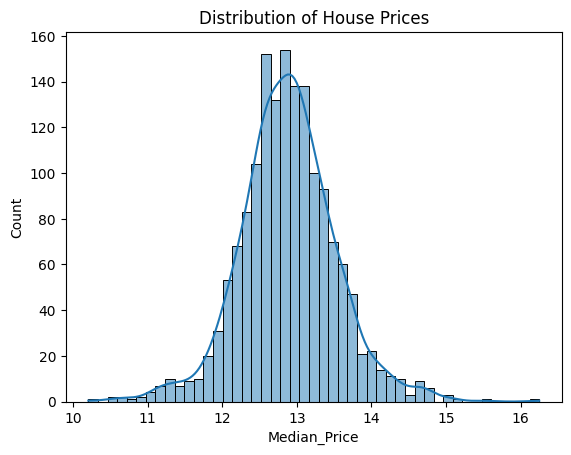

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_train, kde=True)
plt.title("Distribution of House Prices")
plt.show()


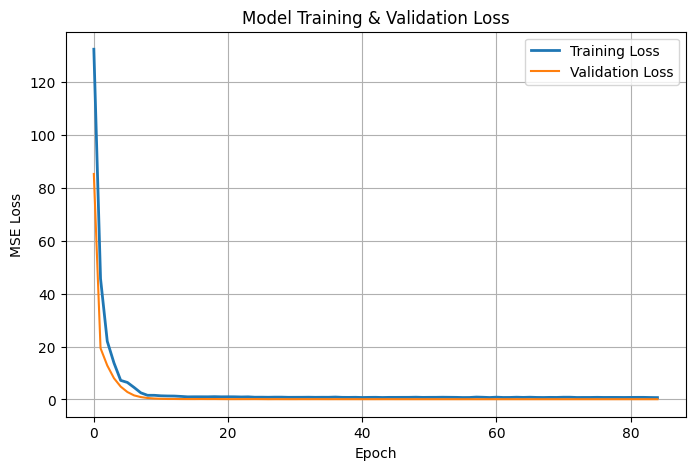

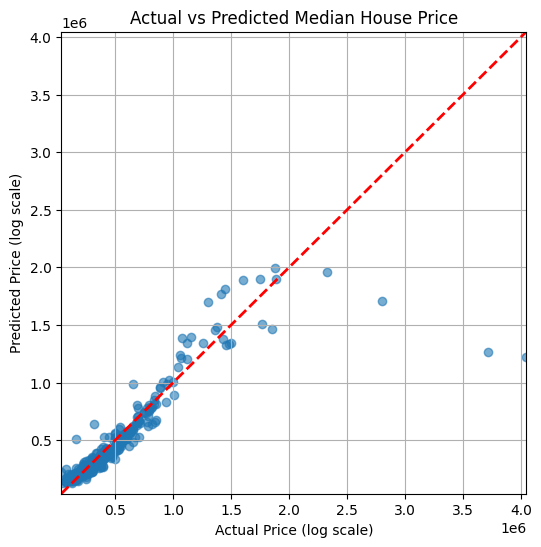

In [58]:
import matplotlib.pyplot as plt

# Viszualization Training Procedure
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Model Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction vs True Room Price
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred, alpha=0.6)

# Calculate the actual minimum and maximum values ​​for the range
lims = [min(y_test_orig.min(), y_pred.min()), max(y_test_orig.max(), y_pred.max())]

# Draw a red dashed line y = x
plt.plot(lims, lims, 'r--', linewidth=2)

# Force the x and y axes to use the same range and ensure the red line is diagonal
plt.xlim(lims)
plt.ylim(lims)

plt.title('Actual vs Predicted Median House Price')
plt.xlabel('Actual Price (log scale)')
plt.ylabel('Predicted Price (log scale)')
plt.grid(True)
plt.show()
